In [32]:
import numpy as np
import pandas as pd
from scipy import signal
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.io as sio

In [33]:
global GROUND_TRUTH
global NUM_CLASSES
GROUND_TRUTH = ['Background', 'Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow',
                        'Fallow_smooth', 'Stubble', 'Celery', 'Grapes_untrained', 'Soil_vinyard_develop',
                        'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk',
                        'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vinyard_untrained', 'Vinyard_vertical_trellis']
NUM_CLASSES = len(GROUND_TRUTH) - 1

### load the dataset

In [34]:
# Get data in '.mat' format, loadmat output 'dict', so need to locate
hsi_image = sio.loadmat('./Salinas_corrected.mat')['salinas_corrected']
gt = sio.loadmat('./Salinas_gt.mat')['salinas_gt']

In [35]:
print(hsi_image.shape)

(512, 217, 204)


### Overall Feature Score

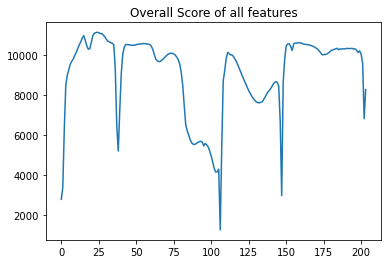

In [36]:
from sklearn.feature_selection import SelectKBest
f_importance = SelectKBest(k=1)
f_importance.fit(hsi_image.reshape(-1,hsi_image.shape[2]), gt.flatten())
plt.plot(f_importance.scores_)
plt.title("Overall Score of all features")
plt.show()

### Plot the curve of one sample

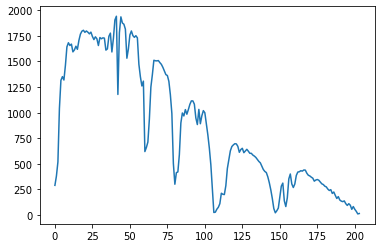

In [37]:
# get any position 
pos = [0,1]
feature = hsi_image[pos[0],pos[1],:]
plt.plot(feature)

### Display a composite color image

ImageView object:
  Display bands       :  (29, 19, 9)
  Interpolation       :  <default>
  RGB data limits     :
    R: [2.0, 8336.0]
    G: [59.0, 9171.0]
    B: [86.0, 8209.0]

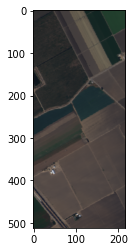

In [38]:
import spectral as spy
spy.imshow(hsi_image,(29, 19, 9))

### Display image with labels

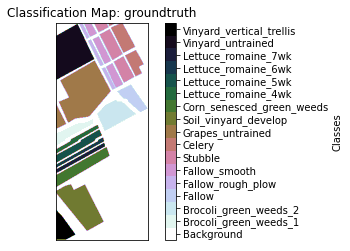

In [39]:
def display_class(data, title=''):
    # this function is from "LEt_SNE_ICASSP2020.ipynb" in "https://github.com/meghshukla/LEt-SNE"
    '''
    NUMPY
    Displays Classification Map
    :param data: 2D Numpy array containing pixel wise labels
    :return: None
    '''
    fig, ax = plt.subplots()

    plt.imshow(data, cmap=plt.cm.get_cmap('cubehelix_r', NUM_CLASSES + 1))
    plt.title('Classification Map: ' + title)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(label='Classes', boundaries=(np.arange(NUM_CLASSES + 2) - 0.5))
    cbar.set_ticks(np.arange(NUM_CLASSES + 1))
    cbar.set_ticklabels(GROUND_TRUTH)

    return None
display_class(gt, 'groundtruth')


## Dataset Pre-possessing

#### Remark: The commented code is a test on our identified limitation:  Adding a Gaussian Blurring

In [40]:
# from skimage.filters import gaussian
# hsi_image = gaussian(hsi_image, sigma=5, channel_axis=True)

### 1. Reshape the 3-D image dataset into a 2-D structural data

In [41]:
data_2d = hsi_image.reshape(hsi_image.shape[0]*hsi_image.shape[1],hsi_image.shape[2])
y_gt = gt.ravel() # convert the 2d groundtruth into a vector

In [42]:
print(data_2d.shape)
print(y_gt.shape)

(111104, 204)
(111104,)


### 2. Data Standardization

In [43]:
from sklearn.preprocessing import StandardScaler
# setup the StandardScaler 
scaler = StandardScaler()
# transform the dataset into the range [0,1]
data_2d = scaler.fit_transform(data_2d)

### 3. Remove the samples labeled with 0

In [44]:
def remove_unclassified_input(X, labels):
    # this function is from "tools.py" in "https://github.com/drguigui1/HSI-Classification/blob/main/src/tools.py"
    '''
    Remove unclassified data from the input (label == 0)
    params
    ----------
    X: Input data, array of shape (n_samples, n_features)
    labels: Labels array of shape (n_pixels_row, n_pixels_col)
    returns
    ----------
    new_X: New data with classified data of shape (n_samples_usefull, n_features)
    arr_idx: Indexes of usefull data in the input image, array of shape (n_samples_usefull,)
    '''
    X_cpy = X.copy()
    idx = np.argwhere(labels.flatten() == 0).flatten()
    mask = np.ones(labels.flatten().shape, dtype=bool)
    mask[idx] = False
    arr = np.arange(labels.size)
    return X_cpy[mask], arr[mask]

In [45]:
X = data_2d
y = gt
X, X_idx = remove_unclassified_input(X, y)
y, _ = remove_unclassified_input(y.flatten(), y)

In [46]:
print(X.shape)
print(y.shape)

(54129, 204)
(54129,)


### PCA

In [47]:
def get_number_components(X):
        # this function is from "tools.py" in "https://github.com/drguigui1/HSI-Classification/blob/main/src/tools.py"
    # first PCA with by keeping all features
    print("Fitting the PCA")
    pca_model = PCA()
    pca_model.fit(X)
    var_cumsum = pca_model.explained_variance_ratio_.cumsum()
    return len(var_cumsum[var_cumsum <= 0.988])

def extract_features(X, n_components):
        # this function is from "tools.py" in "https://github.com/drguigui1/HSI-Classification/blob/main/src/tools.py"
    '''
    Extract features using PCA
    params
    ----------
    X: Input data of shape (n_samples, n_features)
    n_components: Number of components to extract (int)
    returns
    ----------
    reduced_X: New data with few dimensions, after features extraction
        array of shape (n_samples, n_components)
    '''
    pca_model = PCA(n_components=n_components)
    pca_model.fit(X)
    return pca_model.transform(X)

In [48]:
from sklearn.decomposition import PCA
n_components = get_number_components(X)
X_reduced = extract_features(X, n_components)
print(X_reduced.shape)

Fitting the PCA
(54129, 5)


### Partition dataset

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=88)

### Gaussian Bayes Classifier (MLE)

In [89]:
from scipy.stats import multivariate_normal
def fit(train,label):
    class_list = []
    for i in range(NUM_CLASSES):
        label_idx = np.argwhere(label == i+1).flatten()
        class_i = train[label_idx]
        class_list.append(class_i)

    mu_list = []
    cov_list = []
    for item in class_list:
        mu_class = np.mean(item,0)
        cov_class = np.cov(item, rowvar=False)
        mu_list.append(mu_class)
        cov_list.append(cov_class)
    return mu_list,cov_list

def predict(test, mu_list, cov_list):
    y = np.zeros((test.shape[0],NUM_CLASSES))
    for i in range(NUM_CLASSES):
        y1 = multivariate_normal.pdf(test, mu_list[i], cov_list[i])
        y[:,i]=y1
    y_pred = np.argmax(y, axis=1)+1
    return y_pred

In [90]:
# Cross Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
skf = StratifiedKFold(n_splits=6)

cross_validate_scores = []
for train_index, validate_index in skf.split(X_train, y_train):
    x_train, x_validate = X_train[train_index], X_train[validate_index]
    y_sectrain, y_validate = y_train[train_index], y_train[validate_index]

    mu, cov = fit(x_train, y_sectrain)
    class_pred = predict(x_validate, mu, cov)
    scores = accuracy_score(y_validate, class_pred)
    cross_validate_scores.append(scores)

print('Mean Cross Validation Score: ', np.array(cross_validate_scores).mean())

Mean Cross Validation Score:  0.86153395346586


In [91]:

from sklearn import metrics

import time

start_time = time.time()
mu_list,cov_list=fit(X_train,y_train)
y_pred = predict(X_test,mu_list,cov_list)
print("Accruracy:",metrics.accuracy_score(y_test, y_pred)*100)
print("Time spent:", time.time() - start_time)

Accruracy: 85.77498614446702
Time spent: 0.02888965606689453


In [88]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       1.00      0.97      0.98       386
           2       0.99      1.00      0.99       749
           3       0.71      0.98      0.82       385
           4       0.99      1.00      1.00       283
           5       1.00      0.72      0.84       521
           6       1.00      1.00      1.00       778
           7       0.99      0.99      0.99       724
           8       0.82      0.59      0.69      2271
           9       1.00      0.97      0.98      1259
          10       0.80      0.88      0.84       665
          11       0.89      0.98      0.93       245
          12       0.97      0.99      0.98       391
          13       0.97      0.98      0.97       166
          14       0.98      0.93      0.95       215
          15       0.57      0.80      0.66      1423
          16       0.95      0.97      0.96       365

    accuracy                           0.86     10826
   macro avg       0.91   

### Plot the bar chart for the classification result

In [76]:
def plot_histogram_compare_predict_expect(predict, true):
    # this function is from "plot.py" in "https://github.com/drguigui1/HSI-Classification/blob/main/src/plot.py" 
    '''
    Plot histogram and compare to predictions histogram
    params
    ----------
    predict: Predictions array of shape (n_samples,)
    expect: Expectations array of shape (n_samples,)
    title: Matplotlib title
    '''
    fig, axs = plt.subplots(figsize=(20, 6))

    bar_x, bar_count_pred = np.unique(predict, return_counts=True)
    bar1 = axs.bar(bar_x - 0.2, bar_count_pred, 0.4, label="Predicted")

    bar_x, bar_count_exp = np.unique(true, return_counts=True)
    bar2 = axs.bar(bar_x + 0.2, bar_count_exp, 0.4, label="True")

    axs.bar_label(bar1, padding=3)
    axs.bar_label(bar2, padding=3)

    axs.set_xticks(np.arange(1,len(bar_x)+1))
    axs.set_xticklabels(bar_x)

    axs.set_title('Number of Predicted and True Labels', fontdict={'size':17})
    axs.legend()
    plt.show()

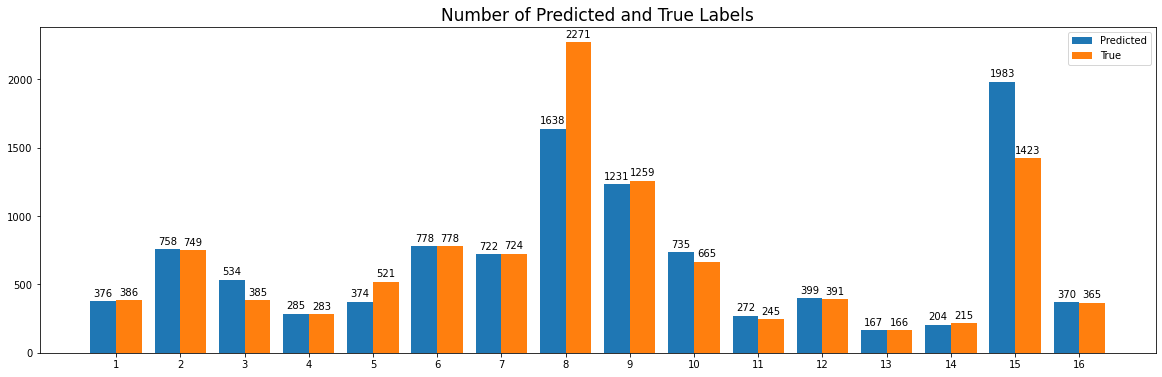

In [77]:
plot_histogram_compare_predict_expect(y_pred, y_test)

### Plot the confusion matrix

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
from matplotlib.colors import LogNorm
def plot_confusion_matrix(labels, preds, class_names, title='Bayes (MLE) Confusion matrix', log=False):
    # this function is from "plot.py" in "https://github.com/drguigui1/HSI-Classification/blob/main/src/plot.py"
    '''
    Plot the confusion matrix
    params
    ----------
    labels: Labels array of shape (n_samples,)
    preds: Predictions array of shape (n_samples,)
    class_names: Names of the different classes
    title: Title of the plot
    log: Logarithm plot
    '''
    # Plot confusion matrix using log / linear scale
    # Get confusion matrix and skip background (label 0)
    matrix = confusion_matrix(labels.flatten(), preds.flatten())

    df = pd.DataFrame({class_names[i]:matrix[:,i] for i in range(len(class_names))}, index=class_names)
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot()
    ax.xaxis.set_ticks_position('bottom')
    if log:
        sn.heatmap(df, annot=True, cmap="OrRd", fmt='g', norm=LogNorm())
    else:
        sn.heatmap(df, annot=True, cmap="OrRd", fmt='g')

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

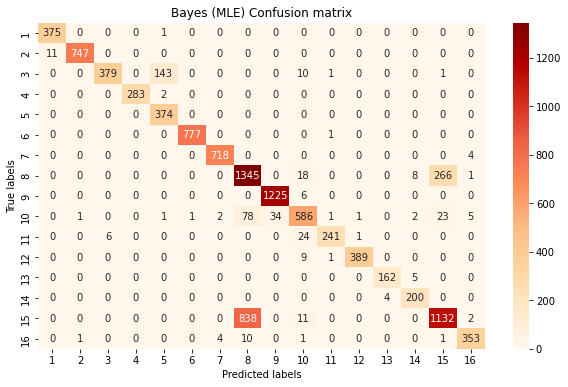

In [79]:
plot_confusion_matrix(y_pred, y_test, class_names=np.arange(1,17).astype(str), log=False)

### Forecast complete image

In [82]:
preds_salinas = predict(X_reduced, mu, cov)

In [83]:
salinas_preds_img = np.zeros((hsi_image.shape[0] * hsi_image.shape[1]))
salinas_label_img = np.zeros((hsi_image.shape[0] * hsi_image.shape[1]))

salinas_preds_img[X_idx] = preds_salinas
salinas_preds_img = salinas_preds_img.reshape((hsi_image.shape[0], hsi_image.shape[1]))

salinas_label_img[X_idx] = y
salinas_label_img = salinas_label_img.reshape((hsi_image.shape[0], hsi_image.shape[1]))

### Classification result visualization

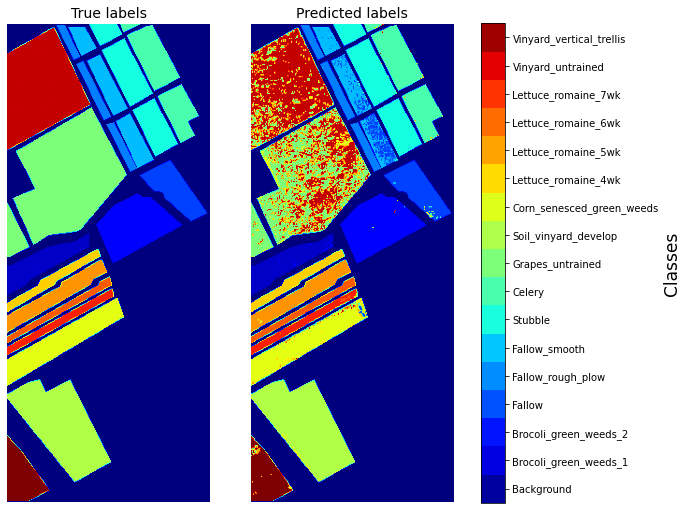

In [71]:
labels = np.dstack((gt,salinas_preds_img))
titles = ['True labels', 'Predicted labels']
fig, axs = plt.subplots(1, 2, figsize=(10, 14))
for col in range(2):
    ax = axs[col]
    ax.axis('off')
    pcm = ax.imshow(labels[:,:,col], cmap='jet')
    ax.set_title(titles[col],fontdict = {'size':14})
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs.ravel().tolist(), boundaries=(np.arange(NUM_CLASSES + 2) - 0.5),shrink=0.63)
cbar.set_label('Classes', fontdict = {'size':17})
cbar.set_ticks(np.arange(NUM_CLASSES + 1))
cbar.set_ticklabels(GROUND_TRUTH)